In [ ]:
import sys
sys.path.append('..')

In [2]:
# Deep Learning
import torch
from torch import nn

# Data Utils
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd

# Hand rolled utils
from util import data, metrics, preprocess
from models import spot, networks

# stats
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import STL
import scipy.stats as stats

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# io
import joblib
import os
from pathlib import Path
import datetime

# notebook params
sns.set()
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['axes.titlesize'] = 20
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Load Data

,b1,b2,b3,b4
2004-02-12 10:32:39,0.058332,0.071832,0.083244,0.043065
2004-02-12 10:42:39,0.058997,0.074008,0.084439,0.044540
2004-02-12 10:52:39,0.060239,0.074223,0.083922,0.044442
2004-02-12 11:02:39,0.061453,0.073843,0.084462,0.045081
2004-02-12 11:12:39,0.061361,0.075606,0.082837,0.045118


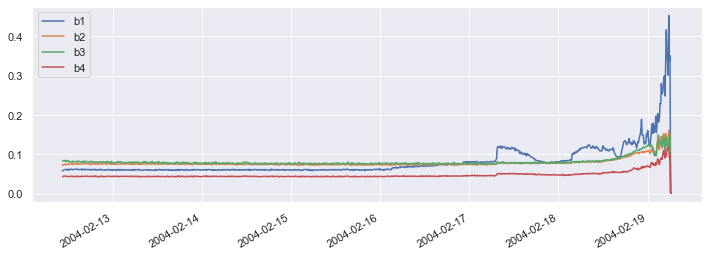

In [3]:
data_dir = Path('data/2nd_test/')
files = [f for f in data_dir.iterdir() if f.is_file()]
vibs_df = pd.DataFrame()

for f in files:
    ten_min_mean = pd.read_csv(f, sep='\t', header=None).abs().mean(axis=0)
    vibs_df = vibs_df.append(ten_min_mean, ignore_index=True)

# create date-time index and columns:
vibs_df.index = [f.name for f in files]
vibs_df.index = pd.to_datetime(vibs_df.index, format='%Y.%m.%d.%H.%M.%S')
vibs_df.columns = ['b1', 'b2', 'b3', 'b4']
vibs_df.sort_index(inplace=True)

vibs_df.plot()
vibs_df.head()

## Preprocess to Dataset/DataLoaders

In [4]:
window = 7
n_features = 4
factor = 2
emb_size = int(window * n_features * factor)

In [5]:
seqs = preprocess.sequence(vibs_df, window)

transform = preprocess.Difference()
train_data = data.SimpleDataset(seqs, transform=transform)
train_loader = DataLoader(train_data, shuffle=True)

## Initialize and Train New Model

In [6]:
model = networks.LSTMEncoderDecoder(n_features, emb_size)

In [7]:
criterion = nn.MSELoss(reduction='sum')
lr = 1e-3
loss = networks.train_encoder(model, 
                             epochs=1000, 
                             lr=lr, 
                             criterion=criterion,
                             trainload=train_loader,
                             testload=train_loader)

Training model on cpu


  0%|          | 0/1000 [00:00<?, ?it/s]

No improvement in 20 epochs. Interrupting training.
Best loss: 0.00024113402126723876
Loading best model weights.
Training complete.


## Visualize Loss

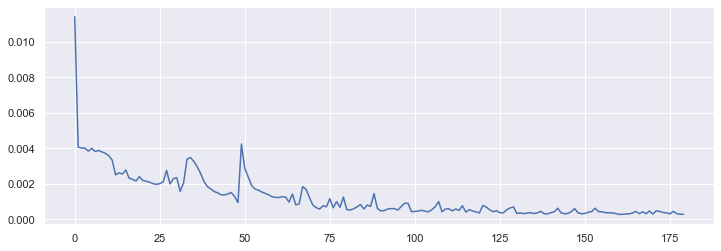

In [8]:
sns.lineplot(data=loss[0]);

In [9]:
torch.save(model.state_dict(), f'models/lstm_model_size={emb_size}_lr={lr}.pt')

# Visualize Reconstruction

In [10]:
# Get a random sample:
sample = seqs[30]

# apply difference transform
sample = transform(sample)
sample.shape

torch.Size([7, 4])

In [11]:
# add dimensions for batch size and # features
sample = sample.unsqueeze(0).float()

out = model(sample)

In [12]:
# invert difference transform
sample = transform.inverse(sample.squeeze())
out = transform.inverse(out.squeeze())

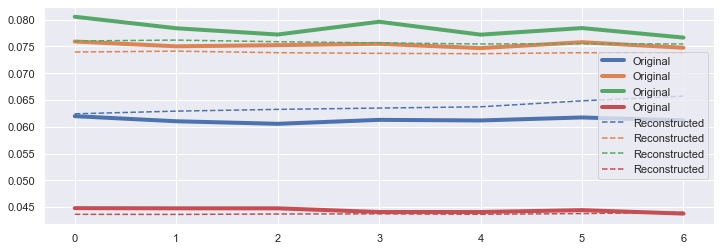

In [13]:
# plot original and reconstruction
plt.plot(sample.detach().numpy().squeeze(), linestyle='-', linewidth=4, label='Original')
plt.gca().set_prop_cycle(None)
plt.plot(out.detach().numpy().squeeze(), linestyle='--', label='Reconstructed')
plt.legend()

## Run Inference on Data

In [14]:
# Run inference on all data.
reconstructed = torch.tensor([])
for seq in train_data:
    x = seq.unsqueeze(0).float()
    with torch.no_grad():
        x_hat = model(x)
        reconstructed = torch.cat((reconstructed, x_hat))

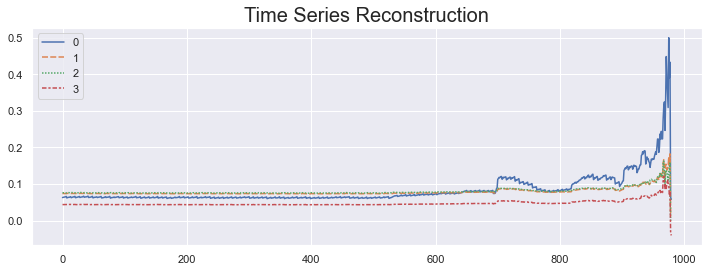

In [15]:
# Invert difference transform
reconstructed = torch.stack([transform.inverse(seq) for seq in reconstructed])

# Concatenate sub-sequences
reconstructed = reconstructed.view(-1, n_features)

sns.lineplot(data=reconstructed.numpy())
plt.title('Time Series Reconstruction');

## Compute Anomaly Scores

In [16]:
# Get L1 Loss of whole data set.
original = torch.cat(tuple(seqs))
criterion = nn.L1Loss(reduction='none')
loss = criterion(reconstructed, original).mean(axis=1)
loss.shape

torch.Size([980])

In [17]:
# Build cumulative density function from loss
cdf = ECDF(loss.squeeze())

# Get threshold
thresh = next(x for x in loss if cdf(x) > 0.997)

# get x, y coordinates for plotting anoms.
x = np.where(loss > thresh)[0]
y = loss[loss > thresh]

## Visualize Anomalies (without SPOT)

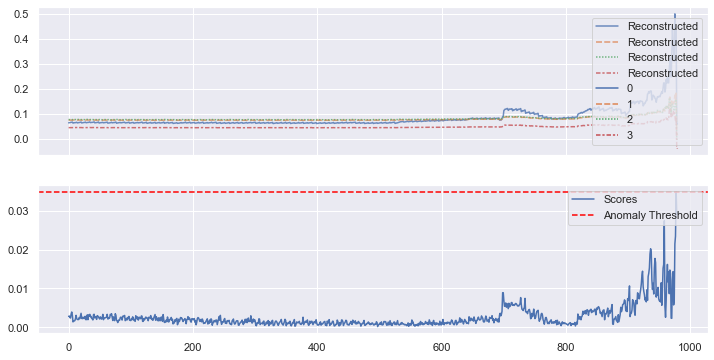

In [18]:
fig, ax, = plt.subplots(2, 1, sharex=True, figsize=(12, 6))

# Reconstruction
sns.lineplot(data=reconstructed.numpy(), linestyle='--', alpha=0.8, ax=ax[0], label='Reconstructed')

# Anomaly detection
sns.lineplot(data=loss, label='Scores', ax=ax[1])
sns.scatterplot(x=x, y=y, color='red', ax=ax[1], label='Anomalies', zorder=3)
ax[1].axhline(y=thresh, c='red', linestyle='--', label='Anomaly Threshold')

plt.legend(loc='upper right')
plt.show()

## Use SPOT:

Initial threshold : 0.0033675463259220106
Number of peaks : 7
Grimshaw maximum log-likelihood estimation ... bounds0 -1675.9847853268675
bounds1 -1e-08
step 152.36225321062432
bounds0 1594354.556973274
bounds1 223915706.36380807
step 20211031.982439525
[done]
	γ = -1.7493784199018592e-12
	σ = 0.00017491582904219523
	L = 53.558312808826905
Extreme quantile (probability = 0.0001): 0.004270954335004446


  0%|          | 0/580 [00:00<?, ?it/s]

bounds0 -1675.9847853268675
bounds1 -1e-08
step 152.36225321062432
bounds0 1595056.4375067584
bounds1 238665155.8962088
step 21551827.223518368
bounds0 -1280.661577095749
bounds1 -1e-08
step 116.4237797350681
bounds0 1597864.839838008
bounds1 323827065.9955238
step 29293563.74142598
bounds0 -1023.3847682784397
bounds1 -1e-08
step 93.03497893349451
bounds0 1599632.3432288333
bounds1 417265530.6516515
step 37787808.93712933
bounds0 -690.4373875963884
bounds1 -1e-08
step 62.767035235126215
bounds0 1601104.704183792
bounds1 548944065.808868
step 49758451.009516746
bounds0 -562.6571440986612
bounds1 -1e-08
step 51.150649462605564
bounds0 1602081.4678390326
bounds1 694015720.1377943
step 62946694.424541384
bounds0 -562.6571440986612
bounds1 -1e-08
step 51.150649462605564
bounds0 1602137.4399900201
bounds1 704680432.6043085
step 63916208.651301675
bounds0 -562.6571440986612
bounds1 -1e-08
step 51.150649462605564
bounds0 1602167.3684899725
bounds1 710518171.9582257
step 64446909.5081578
bounds

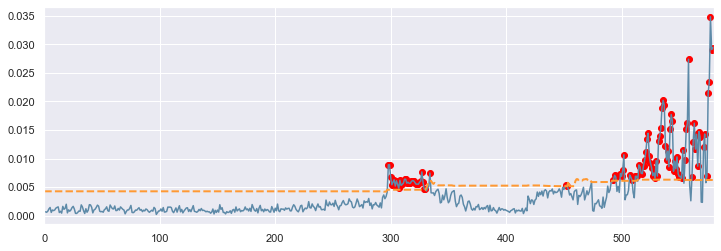

In [19]:
from models import spot

# Split data for initialization step
init_split = 0.25
init_index = int(0.25 * len(loss))
init_data = loss[:400].numpy()

# Remainder is data fro run
run_data = loss[400:].numpy()

# Risk threshold (probability)
q = 1e-2

# Initialize
sp = spot.SPOT()
sp.fit(init_data, run_data)
sp.initialize(level=0.98)

# Run
results = sp.run()

# Plot
fig = sp.plot(results);